In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

Image.MAX_IMAGE_PIXELS = None

### **Check cell and nuclei shapes**

In [4]:
cells_df = pd.read_csv("../Example_Data/H1-TXK6Z4X-A1_2um/cells_df.csv", index_col=0)
cells_df = cells_df.rename(columns={'geometry': 'cell_geometry'})
cells_df.head()

,cell_geometry,id,cell_x,cell_y,centroid
0,POLYGON ((3539.9441674419336 3769.258254359517...,ID_1,3526.907774,3780.083146,"(3526.9077741952688, 3780.083145656686)"
1,POLYGON ((3259.9767676062625 3780.780592424797...,ID_2,3242.404721,3783.507154,"(3242.404721434299, 3783.5071544736184)"
2,POLYGON ((3321.8810815641204 3781.846387962941...,ID_3,3337.708031,3774.951227,"(3337.7080310690203, 3774.9512271879466)"
3,POLYGON ((3382.337656078696 3856.7605066752103...,ID_4,3366.815030,3862.560390,"(3366.81503006682, 3862.560389763742)"
4,POLYGON ((3729.9565297446393 3757.296082942188...,ID_5,3722.221025,3772.751682,"(3722.221024844439, 3772.751681505569)"


In [5]:
nuclei_df = pd.read_csv("../Example_Data/H1-TXK6Z4X-A1_2um/nuclei_df.csv", index_col=0)
nuclei_df = nuclei_df.rename(columns={'geometry': 'nucleus_geometry'})
nuclei_df.head()

,nucleus_geometry,id,cell_x,cell_y,centroid
0,"POLYGON ((3538.10107421875 3780, 3537.14477539...",ID_1,3526.907774,3780.083146,"(3526.9077741952688, 3780.083145656686)"
1,"POLYGON ((3252.42431640625 3784, 3251.99121093...",ID_2,3242.404721,3783.507154,"(3242.404721434299, 3783.5071544736184)"
2,"POLYGON ((3348.673583984375 3776, 3347.6635742...",ID_3,3337.708031,3774.951227,"(3337.7080310690203, 3774.9512271879466)"
3,"POLYGON ((3376.04931640625 3862, 3376.12304687...",ID_4,3366.815030,3862.560390,"(3366.81503006682, 3862.560389763742)"
4,"POLYGON ((3732.935791015625 3772, 3732.4565429...",ID_5,3722.221025,3772.751682,"(3722.221024844439, 3772.751681505569)"


In [6]:
nuclei_geometry_df = nuclei_df[['id', 'nucleus_geometry']]
cell_nuclei_merged_df = cells_df.merge(nuclei_geometry_df, on='id', how='left')
cell_nuclei_merged_df.drop(columns=['centroid'], inplace=True)
cell_nuclei_merged_df.head()

,cell_geometry,id,cell_x,cell_y,nucleus_geometry
0,POLYGON ((3539.9441674419336 3769.258254359517...,ID_1,3526.907774,3780.083146,"POLYGON ((3538.10107421875 3780, 3537.14477539..."
1,POLYGON ((3259.9767676062625 3780.780592424797...,ID_2,3242.404721,3783.507154,"POLYGON ((3252.42431640625 3784, 3251.99121093..."
2,POLYGON ((3321.8810815641204 3781.846387962941...,ID_3,3337.708031,3774.951227,"POLYGON ((3348.673583984375 3776, 3347.6635742..."
3,POLYGON ((3382.337656078696 3856.7605066752103...,ID_4,3366.815030,3862.560390,"POLYGON ((3376.04931640625 3862, 3376.12304687..."
4,POLYGON ((3729.9565297446393 3757.296082942188...,ID_5,3722.221025,3772.751682,"POLYGON ((3732.935791015625 3772, 3732.4565429..."


In [7]:
# Check for missing values in the merged DataFrame
print(cell_nuclei_merged_df['cell_geometry'].isna().sum())
print(cell_nuclei_merged_df['nucleus_geometry'].isna().sum())

19
0


In [ ]:
# only keep rows where both cell_geometry and nucleus_geometry are non-empty strings
cell_nuclei_merged_df = cell_nuclei_merged_df[
    cell_nuclei_merged_df['cell_geometry'].apply(lambda x: isinstance(x, str) and x.strip() != '') &
    cell_nuclei_merged_df['nucleus_geometry'].apply(lambda x: isinstance(x, str) and x.strip() != '')
].copy()

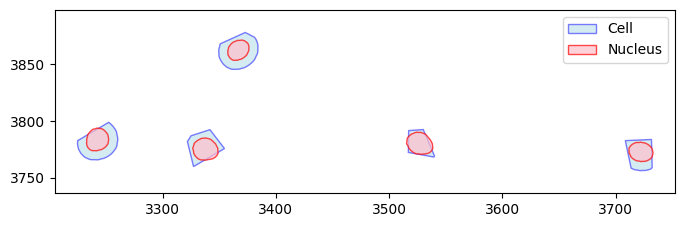

In [ ]:
# visualize the cell and nucleus shapes
from shapely import wkt

fig, ax = plt.subplots(figsize=(8, 8))

for i in range(5):
    row = cell_nuclei_merged_df.iloc[i]
    
    cell = wkt.loads(row['cell_geometry'])
    if cell:
        x, y = cell.exterior.xy
        ax.fill(x, y, facecolor='lightblue', edgecolor='blue', alpha=0.5, label='Cell' if i==0 else "")
    
    nucleus = wkt.loads(row['nucleus_geometry'])
    if nucleus:
        nx, ny = nucleus.exterior.xy
        ax.fill(nx, ny, facecolor='pink', edgecolor='red', alpha=0.7, label='Nucleus' if i==0 else "")

bounds_list = [wkt.loads(row['cell_geometry']).bounds for _, row in cell_nuclei_merged_df.iloc[:5].iterrows() if row['cell_geometry']]
if bounds_list:
    minx = min(b[0] for b in bounds_list) - 20
    miny = min(b[1] for b in bounds_list) - 20
    maxx = max(b[2] for b in bounds_list) + 20
    maxy = max(b[3] for b in bounds_list) + 20
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

ax.set_aspect('equal')
ax.legend()

plt.show()

### **Check gene expression of each single cell**

In [10]:
cell_df = pd.read_csv("../Example_Data/H1-TXK6Z4X-A1_2um/chunks/weighted_by_area/cell_ix_lookup/patch_0_1.csv", index_col=0)
cell_first_5_df = cell_df.head()
cell_first_5_df

,cell_x,cell_y,num_shared_bins,num_unique_bins,id,num_transcripts,chunk_name
0,2761.060679,4233.941919,5.0,93.0,ID_19288,1.0,patch_0_1.csv
1,3663.623038,5479.882963,30.0,28.0,ID_19289,0.0,patch_0_1.csv
2,3708.235662,5807.545700,25.0,22.0,ID_19290,0.0,patch_0_1.csv
3,3435.261755,4261.708850,23.0,27.0,ID_19291,0.0,patch_0_1.csv
4,3206.686382,4120.794516,0.0,109.0,ID_19292,0.0,patch_0_1.csv


In [11]:
gene_df = pd.read_csv("../Example_Data/H1-TXK6Z4X-A1_2um/chunks/weighted_by_area/bin_to_cell_assign/patch_0_1.csv", index_col=0)
gene_first_5_df = gene_df.head()
gene_first_5_df

,PERM1,CCDC27,TNFRSF9,ANGPTL7,C1orf158,PRAMEF11,PRAMEF10,PRAMEF6,PRAMEF18,FHAD1,...,MCF2,MAGEC1,SPANXN3,MAGEA11,MAGEA10,MAGEA6,PNMA6E,TKTL1,RAB39B,NLGN4Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
cell_first_5_id_chunk_df = cell_first_5_df[['id', 'chunk_name']]
cell_first_5_id_chunk_df.head()

,id,chunk_name
0,ID_19288,patch_0_1.csv
1,ID_19289,patch_0_1.csv
2,ID_19290,patch_0_1.csv
3,ID_19291,patch_0_1.csv
4,ID_19292,patch_0_1.csv


In [13]:
merged_df = gene_first_5_df.merge(cell_first_5_id_chunk_df, left_index=True, right_index=True, how='left')
merged_df

,PERM1,CCDC27,TNFRSF9,ANGPTL7,C1orf158,PRAMEF11,PRAMEF10,PRAMEF6,PRAMEF18,FHAD1,...,SPANXN3,MAGEA11,MAGEA10,MAGEA6,PNMA6E,TKTL1,RAB39B,NLGN4Y,id,chunk_name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_19288,patch_0_1.csv
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_19289,patch_0_1.csv
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_19290,patch_0_1.csv
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_19291,patch_0_1.csv
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_19292,patch_0_1.csv


### **Get lite tif image**

In [ ]:
original_image_path = "../Example_Data/H1-TXK6Z4X-A1_2um/H1-TXK6Z4X-A1_SK24-001_A1-4-003.tiff"
tissue_positions_path = "../Backend/Uploaded_Data/tissue_positions.parquet"

# The name of the saved image after cropping
saved_image_path = "../Example_Data/H1-TXK6Z4X-A1_2um/H1-TXK6Z4X-A1_2um_lite.tif"

def load_image(file_path=None):
    """Load image from given file path
    Arguments:
        file_path {string} : path to the file that we are trying to load
    Returns:
        np.array -- loaded image as numpy array
    """
    img_arr = tifi.imread(file_path)
    crop_bounds = get_image_crop_bounds()
    x_min, y_min, x_max, y_max = crop_bounds
    # H&E images have a shape: (height, width, # channels)
    img_arr = img_arr[y_min:y_max, x_min:x_max, :]

    return img_arr, crop_bounds


def get_image_crop_bounds():
        """Get the crop location of the image to adjust the coordinates accordingly

        Returns:
            _type_: _description_
        """
        tissue_pos_list = pd.read_parquet(tissue_positions_path)

        # Cleaning up, removing negative coords,removing out of tissue bins
        tissue_pos_list_filt = tissue_pos_list[tissue_pos_list.in_tissue == 1]
        tissue_pos_list_filt = tissue_pos_list_filt.copy()
        tissue_pos_list_filt["pxl_row_in_fullres"] = tissue_pos_list_filt[
            "pxl_row_in_fullres"
        ].astype(int)
        tissue_pos_list_filt["pxl_col_in_fullres"] = tissue_pos_list_filt[
            "pxl_col_in_fullres"
        ].astype(int)
        tissue_pos_list_filt = tissue_pos_list_filt.loc[
            (tissue_pos_list_filt.pxl_row_in_fullres >= 0)
            & (tissue_pos_list_filt.pxl_col_in_fullres >= 0)
        ]
        x_min = tissue_pos_list_filt["pxl_col_in_fullres"].min()
        y_min = tissue_pos_list_filt["pxl_row_in_fullres"].min()
        x_max = tissue_pos_list_filt["pxl_col_in_fullres"].max()
        y_max = tissue_pos_list_filt["pxl_row_in_fullres"].max()
        return (x_min, y_min, x_max, y_max)

cropped_image, _ = load_image(original_image_path)
cropped_image = Image.fromarray(cropped_image)
cropped_image.save(saved_image_path)

### **Generate HD image(JPEG)**

In [6]:
image_path = "../Example_Data/H1-TXK6Z4X-A1_2um/stardist/he.tiff"
out_put = "../Example_Data/H1-TXK6Z4X-A1_2um/H1-TXK6Z4X-A1_2um_lite.jpeg"
image = Image.open(image_path)
if image.mode != 'RGB':
    image = image.convert('RGB')
image.save(out_put, format='JPEG', quality=100)

In [10]:
# Generate a minimap image
image_path = "../Example_Data/H1-TXK6Z4X-A1_8um/stardist/he.tiff"
out_put = "../Frontend/public/skin_TXK6Z4X_A1_8um_full.jpeg"
image = Image.open(image_path)
if image.mode != 'RGB':
    image = image.convert('RGB')
image.save(out_put, format='JPEG', quality=10)

### **Remove cell boundary image‘s black background**

In [ ]:
image_path = "../Example_Data/H1-TXK6Z4X-D1_2um/cells_layer.png"
output_path = "../Example_Data/H1-TXK6Z4X-D1_2um/cells_layer.png"

image = Image.open(image_path).convert("RGBA")
data = np.array(image)

# Convert to the transparent background
r, g, b, a = data[:,:,0], data[:,:,1], data[:,:,2], data[:,:,3]
mask_black = (r == 0) & (g == 0) & (b == 0)
data[mask_black] = [0, 0, 0, 0]

# Save
new_image = Image.fromarray(data)
new_image.save(output_path)